# DEVALGO test scenes

This notebook illustrates the use of the L1b CIMR data reader. The reader reads data in the L1b format from the SCEPS or DEIMOS CIMR satellite simulator.
Here, the DEVALGO test scenes are used as input data.
All code cells are executed when the notebook is run only requiring the source code in the `algorithm` folder where the reader and algorithm is implemented in the Julia language. In addition a `common_functions.jl` is used, located in this folder.
In this notebook all cells are shown including output from the executed code.

## Overview
The multi parameter retrieval was evaluated on the two DEVALGO test cards, as well as on the SCEPS polar test card. For the DEVALGO test cards, the performance is evaluated by analyzing the difference between the retrieval applied to the input brightness temperatures of the CIMR satellite simulator and the retrieval applied to the output of the simulator, i.e., the CIMR L1b data (from DEIMOS). The retrieval is also applied to the SCEPS polar scene where an absolute reference exists in the next section. The brightness temperature before and after the satellite simulator can be used as retrieval input to estimate the effect the CIMR satellite characteristics have on the multi parameter retrieval. In this section, all resampling was performed using a nearest neighbor interpolation. The variables retrieved in the multi parameter retrieval are wind speed (WS), total water vapor (TWV), cloud liquid water (CLW), sea surface temperature (SST), ice surface temperature (IST), sea ice concentration (SIC), multi year ice fraction (MYI), first year ice thickness (SIT), and sea surface salinity (SSS). In the following, the retrieval results are illustrated only for SIC, but the performance metrics are shown for all variables. 

```{note}
The DEVALGO test scenes 1 and 2 contain artificial patterns of different surface types at the geographic location around Svalbard. Neither the geometric pattern shown in this scene, does not correspond to any real scenario and is only for the purpose of testing the retrieval algorithm. The scenes are generated by the DEVALGO team and are not real observations.
```

In [1]:
using Revise
includet("common_functions.jl")

  Activating project at `/mnt/pharoshome/huntemann/Projects/DEVALGO/MultiParameter_ATBD_V2/algorithm/algoenv`


## Illustration of the reading routines for the data handling

First we are setting up some projection conversion. Since the {term}`CIMR` L1b data is not on a regular grid, the arrays can not be directly plotted on a map. Therefore, we need to convert the data to a projection that can be plotted on a map. 

```{literalinclude} common_functions.jl
:language: julia
:name: include-common_functions
:start-after: "##imports_start"
:end-before: "##imports_end"

Imports the necessary packages and functions for this notebook.
```

In [2]:
#can be aceesed like
fns.scene1.l1b

"/mnt/spaces/Projects/2022_CIMR-DEVALGO/CIMR_L1X/W_PT-DME-Lisbon-SAT-CIMR-1B_C_DME_20230420T103323_LD_20280110T114800_20280110T115700_TN.nc"

```{literalinclude} common_functions.jl
:language: julia
:start-after: "##fns_start"
:end-before: "##fns_end"
```

Simple data reading for a single band can be done with the `get_data_for_band` function. It only requires the filename of the L1b data and the band to be read. It gets a named tuple with, `h`, `v`, `lat` and `lon`. All arrays are 1d arrays. `h` and `v` are the horizontal and vertical brightness temperatures, `lat` and `lon` are the latitude and longitude coordinates. The position in the scan is ignored as the scan direction is already selected by passing "forward" or "backward" to the function. Since this is a raw reader, there is no interpolation or other processing done on the data.

In [3]:
cband_data=get_data_for_band(fns.scene1.l1b,"C_BAND","backward")
@show keys(cband_data) #a named tuple with the keys: h, v, lat, lon,  herr, verr, oza
@show size(cband_data.h);

keys(cband_data) = (:h, :v, :herr, :verr, :lat, :lon, :oza)
size(cband_data.h) = (389932,)


Another possibility is the `project_data` data function. This also reads a file
by name, but also resamples the data onto the closest grid point of the selected
band. The output is three arrays with the reprojected brightness temperatures
for each band, and the latitude and longitude coordinates of the grid points.
The grid points are the same for all bands. The function also takes the scan
direction as an argument. The projected brightness temperatures have the
different channel as second dimension, starting with the lowest frequency at `v`
pol. The `h` pol is the next channel, followed by the next higher frequency at
`v` pol and so on, i.e., 10 dimensions in the order `L_band_v`, `L_band_h`,
`C_band_v`, `C_band_h`, `X_band_v`, `X_band_h`, `Ku_band_v`, `Ku_band_h`,
`Ka_band_v`, `Ka_band_h`. Here we store forward and backward scans in different
arrays, to be able to assess them separately. 
```{note}
The resampling is done by finding the closest grid point in the projection. This is the simplest possible resampling and might not be the best choice for all applications.
```
Here we fill the arrays with the data from the DEVALGO test scene 1, which is the radiometric scene, with the forward and backward scans in separate arrays, accessed as dictionaries.

In [4]:
band_data=Dict()
band_error=Dict()
latc=Dict()
lonc=Dict()
xc=Dict()
yc=Dict()
for dir in ["forward","backward"]
    band_data[dir],band_error[dir],latc[dir],lonc[dir]=project_data(fns.scene1.l1b,"C_BAND",dir)
    xc[dir],yc[dir]=lltoxy.(latc[dir],lonc[dir]) |> x-> (first.(x),last.(x))
    @eval(@show(size(band_data[$dir])))
    @eval(@show(size(latc[$dir])));
end

size(band_data["forward"]) = (366644, 10)
size(latc["forward"]) = (366644,)
size(band_data["backward"]) = (389932, 10)
size(latc["backward"]) = (389932,)


### Illustration of L1b data without resampling
Here it can be seen that the number of data points is different for the different scans. The forward scan contains fewer data points as the calibration is also in forward direction.

Since the data is not on a regular grid, it cannot be plotted directly but has to be converted to earth coordinates, in this case we chose the EASE2 Northern hemisphere grid. Below is a scatter plot of the data points in the EASE2 grid for the Northern hemisphere. For the test scenes, the brightness temperatures outside of the test scene area are 0&nbsp;K. This is why the data points are only visible in the test scene area. Small structures in the data are visible corresponding to scanlines. Exemplary, only TBh at C-band is shown.


size(xc[dir]) = (366644,)
size(yc[dir]) = (366644,)
size((band_data[dir])[:, 4]) = (366644,)
size(xc[dir]) = (389932,)
size(yc[dir]) = (389932,)
size((band_data[dir])[:, 4]) = (389932,)


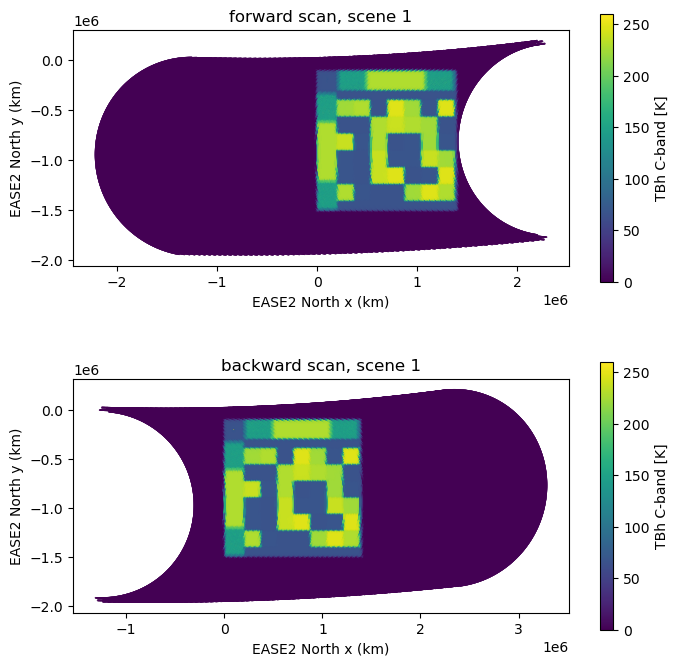

In [5]:

fig,axs=pyplot.subplots(nrows=2,figsize=(8,8))
for (i,dir) in enumerate(["forward","backward"])
    
    im=i-1 #python indexing starts at 0
    @show size(xc[dir])
    @show size(yc[dir])

    @show size(band_data[dir][:,4])
    img=axs[im].scatter(xc[dir],yc[dir],c=band_data[dir][:,4], vmin=0,vmax=260,s=0.05)
    #img=axs[im].scatter(xc[dir],yc[dir],c=band_error[dir][:,4], vmin=0,vmax=2,s=0.05)
    fig.colorbar(img,ax=axs[im],label="TBh C-band [K]")
    axs[im].set_title(dir*" scan, scene 1")
    axs[im].set_aspect("equal")
    axs[im].set_xlabel("EASE2 North x (km)")
    axs[im].set_ylabel("EASE2 North y (km)")
end
fig.subplots_adjust(hspace=0.3)
display("image/png",fig)
pyplot.close(fig)
fig=nothing

### Application of the retrieval on the L1b data
Now we can apply the Multi parameter retrieval using the simple user function `run_oem`. It takes the band data as produced by the `project_data` function, i.e., a matrix with (n, 10) dimensions, where n is the number of data points, and 10 is the number of channels. It returns the retrieved parameters similarly as (n, 9) matrix, where the columns are the retrieved parameters. The columns are the same as in the L1b data, i.e., `wind speed`, `total water vapor`, `cloud liquid water`, `sea surface temperature`, `ice surface temperature`, `sea ice concentration`, `multi year ice fraction`, `first year ice thickness`, `sea surface salinity`. The retrieval is done for each scan separately, i.e., the forward and backward scan are retrieved separately.

| Index | parameter                                               |
|-------|---------------------------------------------------------|
| 1     | wind speed [m/s]                                        |
| 2     | total water vapor [kg/m²]                              |
| 3     | cloud liquid water [kg/m²]                             |
| 4     | sea surface temperature [K]                            |
| 5     | ice surface temperature [K]                            |
| 6     | sea ice concentration [1]                              |
| 7     | multi year ice fraction [1]                            |
| 8     | first year ice thickness [cm]                          |
| 9     | sea surface salinity [ppt]                             |

The routine also returns the square root of the diagonal of the error covariance matrix of the retrieval and the residuals to the input brightness temperatures, together with the number of iterations. 

Here, as an example, we are applying the retrieval to the forward scan and collect the returned variables in a named tuple.

In [6]:
scene1 = Dict()
for dir in ["forward","backward"]
    pygc.collect()
    GC.gc()
    dat,errr,res,its=run_oem(deepcopy(band_data[dir]))#,band_error[dir])
    x,y = xc[dir],yc[dir]; #results from the project_data function above, all still in the scan geometry
    lat,lon = latc[dir],lonc[dir];
    scene1[dir] = (;dat, errr, res, x, y, lat, lon, its) # a named tuple with the results
end

We are providing a cut out of our region of interest, i.e., the location of the test card, in EASE2 projection. This is defined here with the `pyresample` python package.

In [7]:
lea=pr.geometry.AreaDefinition("ease2_nh_testscene","ease2_nh_testscene","ease2_nh_testscene","EPSG:6931",1400,1400,[0,-1.5e6,1.4e6,-1e5]); #uses pyresample to define an area definition for the test region in the EASE2 grid
leaextent=[lea.area_extent[0],lea.area_extent[2],lea.area_extent[1],lea.area_extent[3]] #extent for the image, since order differs from the order in the area definition

#getting the landmask for the region
lealons,lealats=lea.get_lonlats()
landmask = basemap.maskoceans(lealons,lealats,lealats,resolution="i").mask |> PyArray |> Array |> x->.~x 

#defining a cartopy crs
ccrs=lea.to_cartopy_crs()


Python:
<Projected CRS: EPSG:6931>
Name: WGS 84 / NSIDC EASE-Grid 2.0 North
Axis Info [cartesian]:
- X[south]: Easting (metre)
- Y[south]: Northing (metre)
Area of Use:
- name: Northern hemisphere.
- bounds: (-180.0, 0.0, 180.0, 90.0)
Coordinate Operation:
- name: US NSIDC EASE-Grid 2.0 North
- method: Lambert Azimuthal Equal Area
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

## Test scene 1 - Radiometric scene
Now we can plot the image of the retrieved parameters, here we chose the sea ice concentration, i.e., index 6.

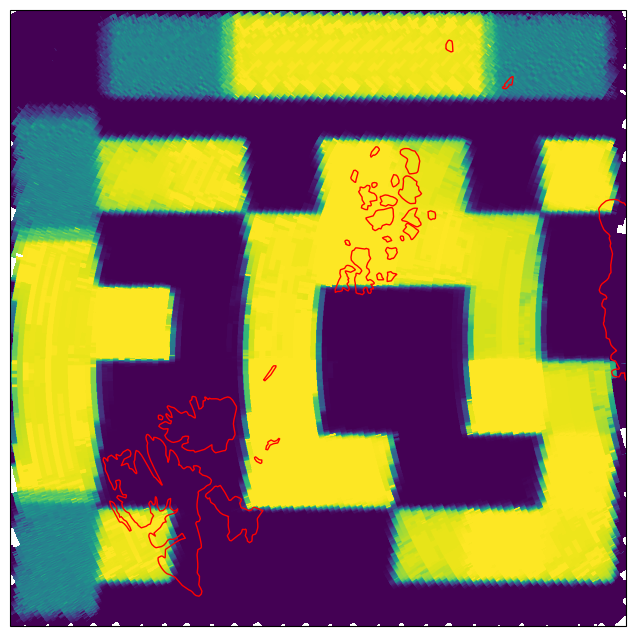

Python: None

In [8]:
let scene1 = scene1["forward"]
    outsic = OEM.project_data_to_area_nn(scene1.dat[:, 6], scene1.lat, scene1.lon, lea)
    fig = pyplot.figure(figsize=(8, 8))
    ax = fig.add_subplot(111, projection=ccrs)
    #outsic[landmask] .= NaN
    ax.imshow(outsic, vmin=0, vmax=1, extent=leaextent, transform=ccrs)

    ax.coastlines(color="red")
    display(fig)
    pyplot.close(fig)
end

### Overview of surface classes and true brightness temperatures

For the interpretation of the retrieval results, we can also plot the surface classes. The surface classes were defined in the DEVALGO test cards and were input to several forward models to generate brightness temperatures. 

The data for the surface classes is stored in the test scene files. For comparison we can plot the retrieved data on the original input brightness temperature before the CIMR satellite simulator. For Test scenes 1 and 2, the helper function `read_testscene` can be used. It reads the data from the test scenes and returns the brightness temperatures and the pyresample area definition and the image extent. The data block is also a 2d array with the dimensions (n, 10), where n is the number of data points, and 10 is the number of channels. This is to be able to use the same retrieval function for this dataset. The number of datapoints n, is here 1400*1400, i.e., the number of pixels in the test scene. The area definition is the same as for the CIMR data, i.e., EASE2 North 1km. The image extent is the extent of the image in the projection coordinates. This is needed to plot the data on the map.

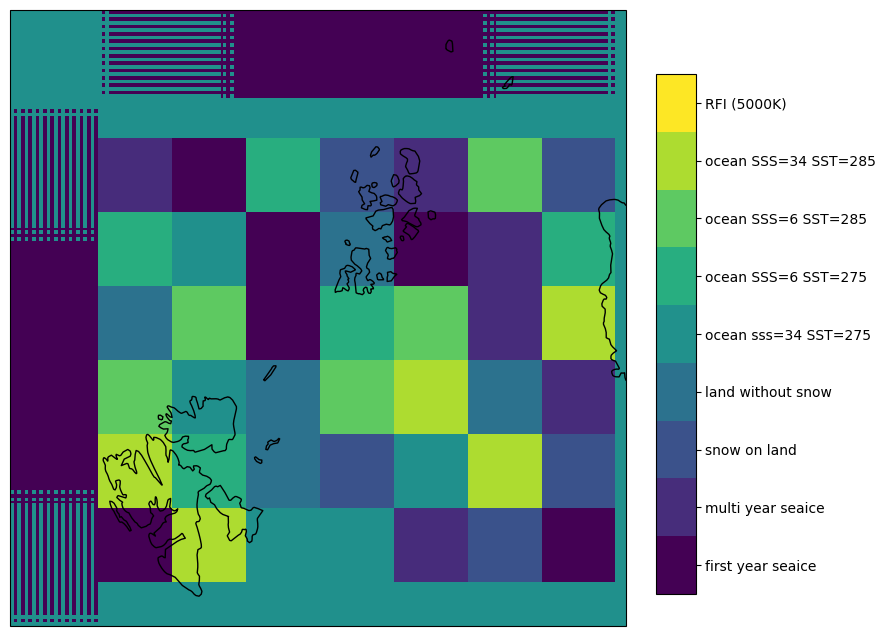

In [9]:
testinput, mea, imextent, surfaces=read_testscene(fns.scene1.input)

surface_names=["first year seaice",
"multi year seaice",
"snow on land",
"land without snow",
"ocean sss=34 SST=275",
"ocean SSS=6 SST=275",
"ocean SSS=6 SST=285",
"ocean SSS=34 SST=285",
"RFI (5000K)"]

cmap = matplotlib.cm.get_cmap("viridis", 9)

fig = pyplot.figure(figsize=(10,8))
ax = fig.add_subplot(111, projection=ccrs)
im=ax.imshow(surfaces[end:-1:1,:], extent=imextent, cmap=cmap,interpolation="nearest",vmin=0.5,vmax=9.5)

cbar_ax = fig.add_axes([0.85, 0.15, 0.04, 0.65])

cbar = fig.colorbar(im, cax=cbar_ax, ticks=1:9, orientation="vertical")
#now only show the range 0.5 to 9.5 area of the colorbar, so the surface names are centered for each color and there is no unused color
cbar.set_ticks(1:9)
cbar.ax.set_yticklabels(surface_names)

ax.coastlines()

pyplot.savefig("figures/surfaces_scene1.png",dpi=200,bbox_inches="tight")


display("image/png",fig)
pyplot.close(fig)
fig=nothing


We can plot all retrieved parameters in a single plot. We chose to define the plotting in a function, to reuse it for the backward scan and the other scenes.

```{literalinclude} common_functions.jl
:language: julia
:start-after: "##plot_all_params_start"
:end-before: "##plot_all_params_end"
```




Plotting the results resampled to the surface grid 1km EASE2 North. The scan lines are barely visible. In this plot the sea ice concentration defines the mask for the other parameters. Wind speed, sea surface temperature and sea surface salinity are shown for small sea ice concentrations while ice surface temperature, sea ice thickness and multi year ice fraction are shown only for higher sea ice concentrations. The total water vapor and cloud liquid water are shown for all sea ice concentrations.

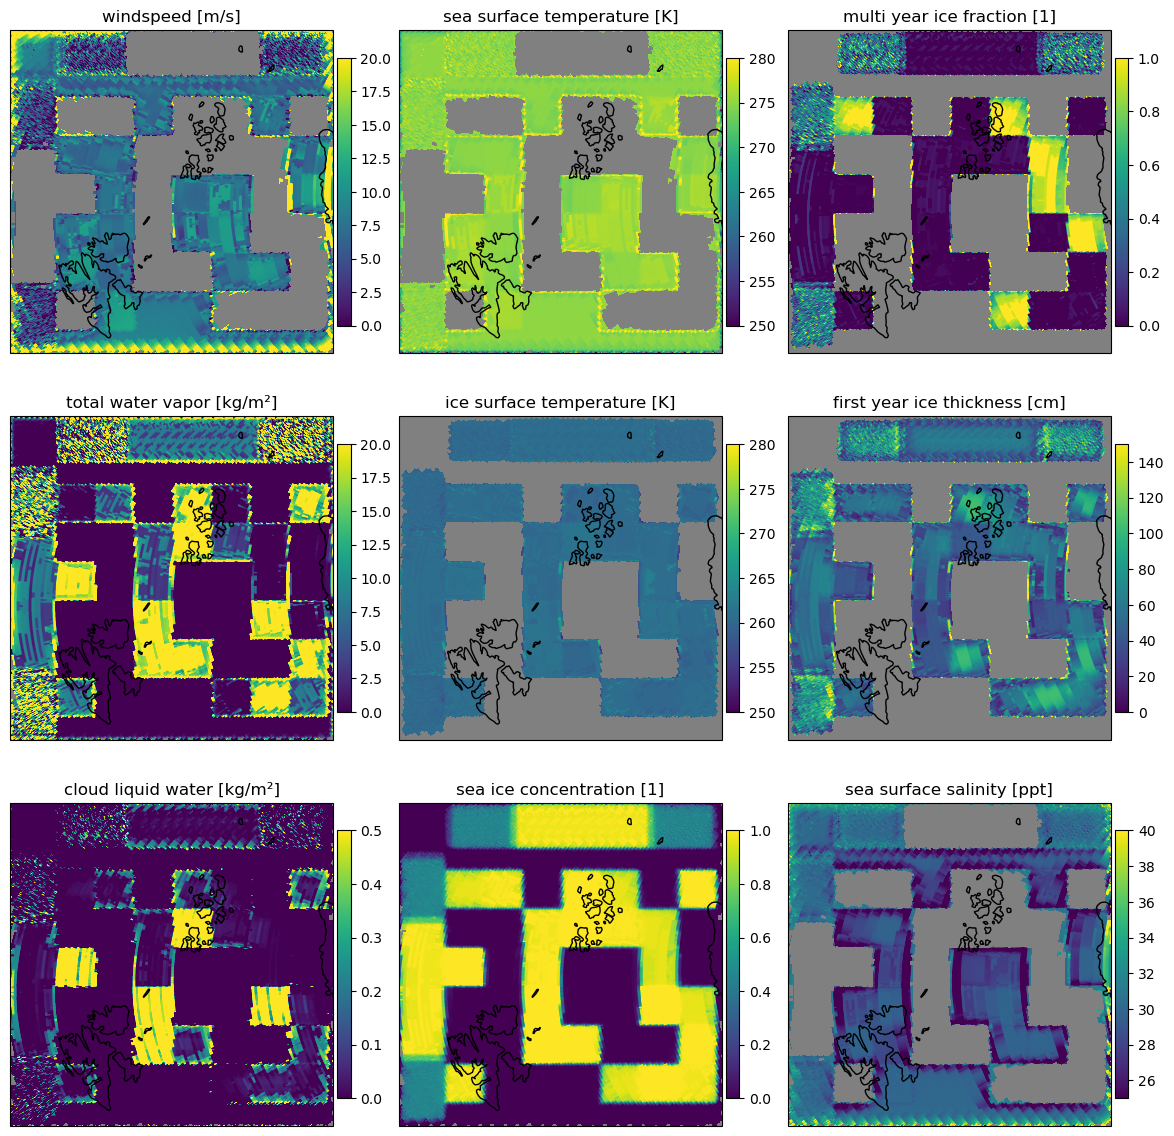

Python: None

In [10]:
let dir = "forward"
    fig=plot_all_params(scene1,dir,swath=false,mask=(:sic,),errors=:false,save="figures/scene1_oem_results.png")
    display("image/png",fig)
    pyplot.close(fig)
end

Despite the forward model not including land surfaces, the retrieval is also run over the land surfaces brightness temperatures.

The uncertainties can be displayed as the square root of the diagonal of the error covariance matrix of the retrieval. From the uncertainties it can be seen that the forward model is not really able to reproduce the brightness temperatures over land surfaces. The uncertainties are very high for the land surfaces, in particular in the cloud liquid water and total water vapor retrieval. The sea ice concentration shows the lowest uncertainties as the sensitivity of the forward model is highest for this parameter. For multi year ice areas which are also retrieved as high multi year ice fraction, the uncertainty of the first year ice thickness retrieval is high as there is little first year ice present.

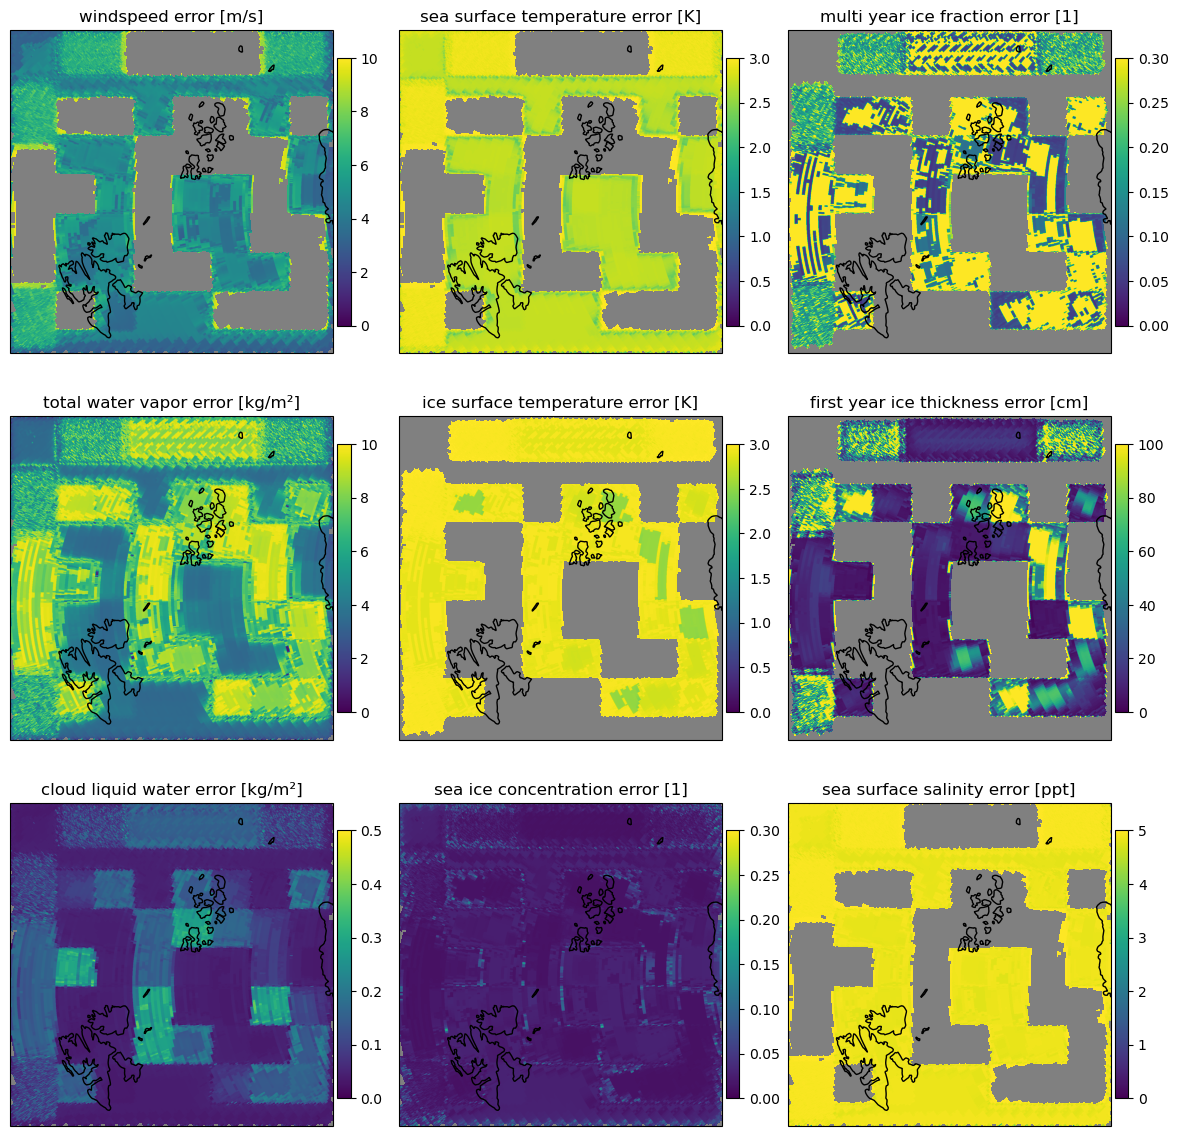

Python: None

In [11]:
let dir = "forward"
    fig=plot_all_params(scene1,dir,swath=false,mask=(:sic,),errors=:std,save="figures/scene1_oem_errors.png")
    display("image/png",fig)
    pyplot.close(fig)
end

In addition to the uncertainty of the retrieval in this Bayesian method, the gained knowledge of the parameters can be assessed. Here we use the 1-uncertainty ratio as a measure of how much our knowledge of each parameter is improved by doing the retrieval, compared to prior knowledge. 
```{note}
The 1-uncertainty ratio (in words: one minus uncertainty ratio) is calculated as the ratio of the prior uncertainty to the posterior uncertainty. A value of 0 means that the retrieval did not improve the knowledge of the parameter, a value of 1 means that the retrieval greatly improved the knowledge of the parameter. As a consequence, this gain in knowledge depends strongly on the prior knowledge of the parameter.
```

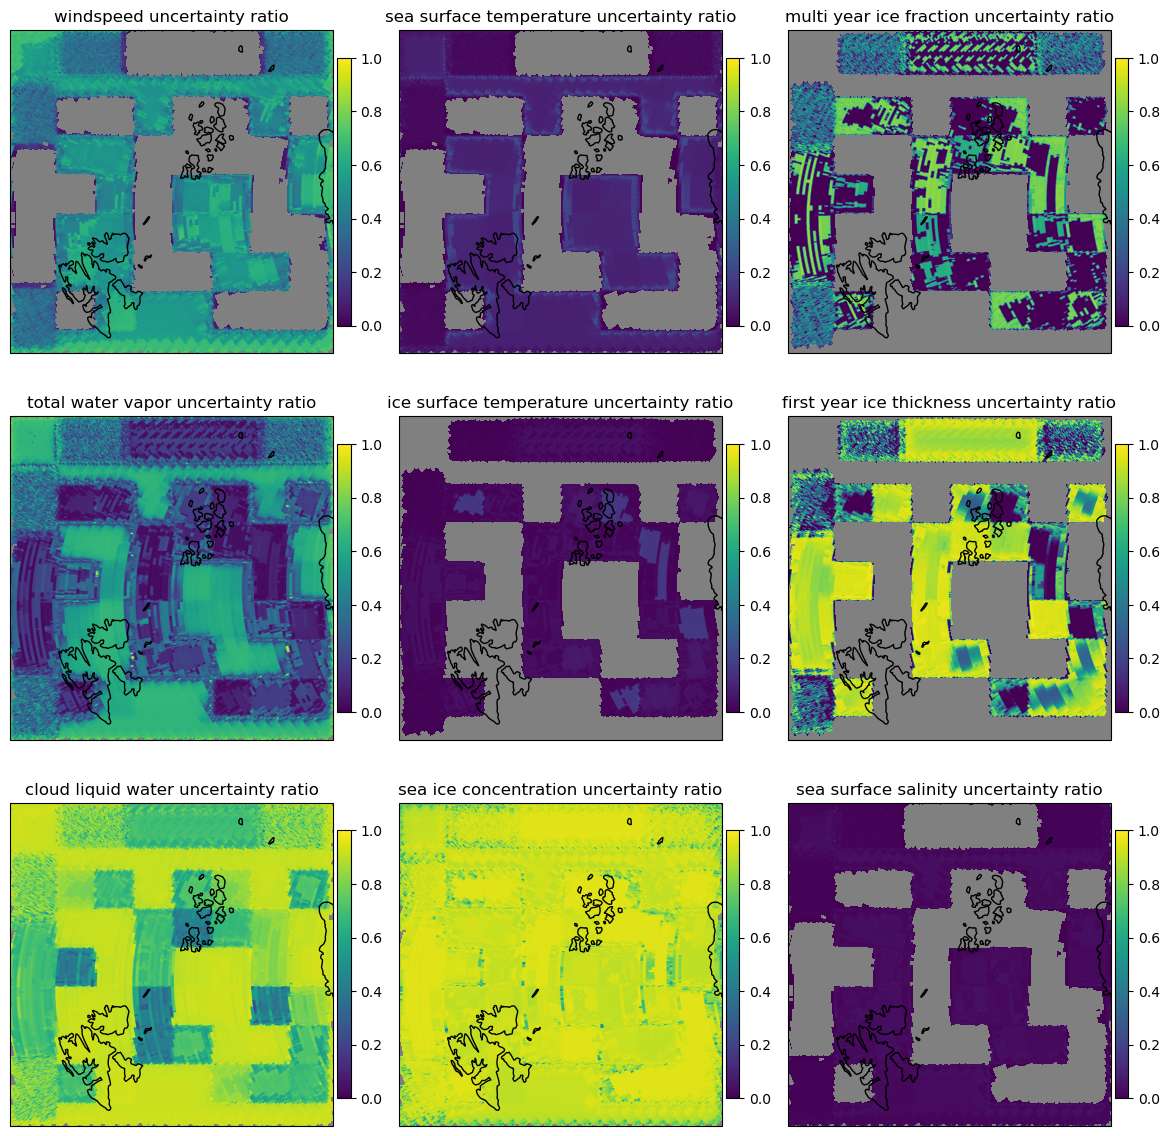

Python: None

In [12]:
let dir = "forward"
    fig=plot_all_params(scene1,dir,swath=false,mask=(:sic,),errors=:ratio,save="figures/scene1_oem_ratios.png")
    display("image/png",fig)
    pyplot.close(fig)
end

We also apply the retrieval directly to the input data now.


In [13]:
pygc.collect()
GC.gc()
tdat,terr,tres=run_oem(deepcopy(testinput))

gdata1 = NamedTuple{(:ws, :twv, :clw, :sst, :ist, :sic, :myi, :sit, :sss)}(reshape(tdat[:,i],1400,1400)[end:-1:1,:] for i in 1:9)


(ws = [8.606775086416485 8.606775086416485 … 8.606775086416485 8.606775086416485; 8.606775086416485 8.606775086416485 … 8.606775086416485 8.606775086416485; … ; 8.606775086416485 8.606775086416485 … 8.606775086416485 8.606775086416485; 5.005320129782621 8.606775086416485 … 8.606775086416485 8.606775086416485], twv = [-1.041070439268596 -1.041070439268596 … -1.041070439268596 -1.041070439268596; -1.041070439268596 -1.041070439268596 … -1.041070439268596 -1.041070439268596; … ; -1.041070439268596 -1.041070439268596 … -1.041070439268596 -1.041070439268596; 3.5621438953996463 -1.041070439268596 … -1.041070439268596 -1.041070439268596], clw = [-0.19217235888038275 -0.19217235888038275 … -0.19217235888038275 -0.19217235888038275; -0.19217235888038275 -0.19217235888038275 … -0.19217235888038275 -0.19217235888038275; … ; -0.19217235888038275 -0.19217235888038275 … -0.19217235888038275 -0.19217235888038275; 0.019041203464365785 -0.19217235888038275 … -0.19217235888038275 -0.19217235888038275], 

Now comparing the retrieved sea ice concentration from the CIMR L1b simulated data to the sea ice concentration retrieved from the input data (to the simulator). The difference is very small, which is expected as the simulator is only modifying the input brightness temperature according to the CIMR instrument geometry. The difference is only visible at the ice edges and at the intermediate ice concentration where slight scan pattern are visible from the simulated L1b data.

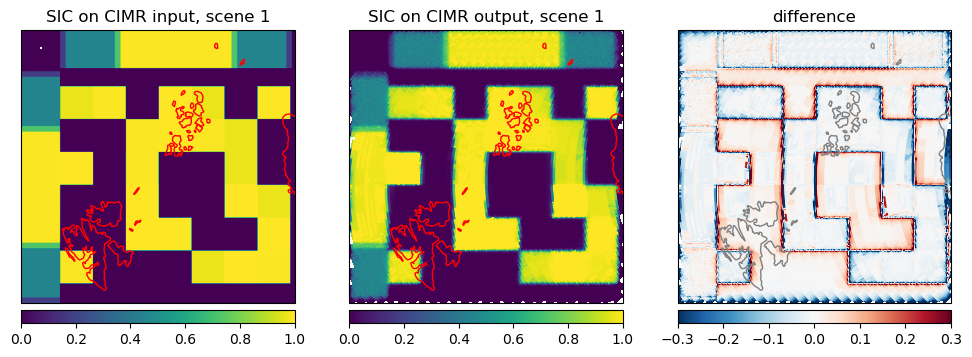

Python: None

In [14]:
let scene1 = scene1["forward"]
    fig = pyplot.figure(figsize=(12, 8))

    ax = fig.add_subplot(131, projection=ccrs)
    ax.set_title("SIC on CIMR input, scene 1")
    im=ax.imshow(gdata1.sic,zorder=1,extent=imextent,vmin=0,vmax=1)
    ax.coastlines(color="red")
    pyplot.colorbar(im,orientation="horizontal",pad=0.01)

    outsic=OEM.project_data_to_area_nn(scene1.dat[:,6],scene1.lat,scene1.lon,lea)
    ax = fig.add_subplot(132, projection=ccrs)
    ax.set_title("SIC on CIMR output, scene 1")
    im=ax.imshow(outsic, vmin=0, vmax=1, extent=leaextent, transform=ccrs)
    ax.coastlines(color="red")
    pyplot.colorbar(im,orientation="horizontal",pad=0.01)

    ax = fig.add_subplot(133, projection=ccrs)
    ax.set_title("difference")
    im=ax.imshow(outsic.-gdata1.sic, vmin=-0.3, vmax=0.3, extent=leaextent, transform=ccrs,cmap="RdBu_r")
    pyplot.colorbar(im,orientation="horizontal",pad=0.01)

    ax.coastlines(color="gray")
    pyplot.savefig("figures/sic_comparison_scene1.png",dpi=200,bbox_inches="tight")
    display("image/png",fig)
    pyplot.close(fig)
end


Now we can also calculate the difference between all parameters of the retrieval from the L1b data and the input data. For this we define a helper function to calculate the difference between the retrieval on the input TB and L1b simulation output. Little differences are expected originating only from the satellite simulator edge effects.
    
```{literalinclude} common_functions.jl
:language: julia
:start-after: "##calculate_overall_performance_start"
:end-before: "##calculate_overall_performance_end"
```


In [41]:
calculate_overall_performances([scene1], [gdata1], ["combined"], [100]) |> x-> markdown_table(x,"scene 1","1",include_mean=true,show_units=true) |> x->display("text/markdown",Markdown.parse(x));

````markdown
```{list-table} Performance metric for scene 1
:name: "performance-1"
:header-rows: 1

# table content (skipped in notebook) ```
````

|    Variable | cb mean value | cb mean(diff) | cb std(diff) |
| -----------:| -------------:| -------------:| ------------:|
|    WS [m/s] |         9.189 |        -1.124 |        4.896 |
| TWV [kg/m²] |         3.286 |         1.033 |       11.918 |
| CLW [kg/m²] |        -0.023 |         0.007 |        0.212 |
|     SST [K] |       275.082 |         0.014 |        1.283 |
|     IST [K] |       260.380 |        -0.362 |        1.302 |
|     SIC [1] |         0.482 |         0.003 |        0.186 |
|     MYI [1] |         0.253 |         0.128 |        0.377 |
|    SIT [cm] |        81.951 |        13.787 |       61.831 |
|   SSS [ppt] |        30.004 |        -0.829 |        2.210 |


In table {numref}`performance-1` the mean difference and the root mean square difference between the retrieved parameters from the input data and the L1b data are shown in forward (fw) and backwards (bw) direction. The differences are very small as expected. The differences are only visible at the ice edges and at the intermediate ice concentration where slight scan pattern are visible from the simulated L1b data.

## Test scene 2 - Geometric scene
We perform the same comparison for the test scene 2, also for the forward scan. This scene is also called the *geometric scene*.

In [23]:
#get cimer results
#scene2 = let dir="forward"
scene2 = Dict()
for dir in ["forward","backward"]
    test2datac,test2derror,lat,lon=project_data(fns.scene2.l1b,"C_BAND",dir)
    x,y=lltoxy.(lat,lon) |> x-> (first.(x),last.(x))
    pygc.collect()
    GC.gc()
    dat,err,res=run_oem(deepcopy(test2datac))
    scene2[dir] = (; dat, err, res, x, y, lat, lon)
end



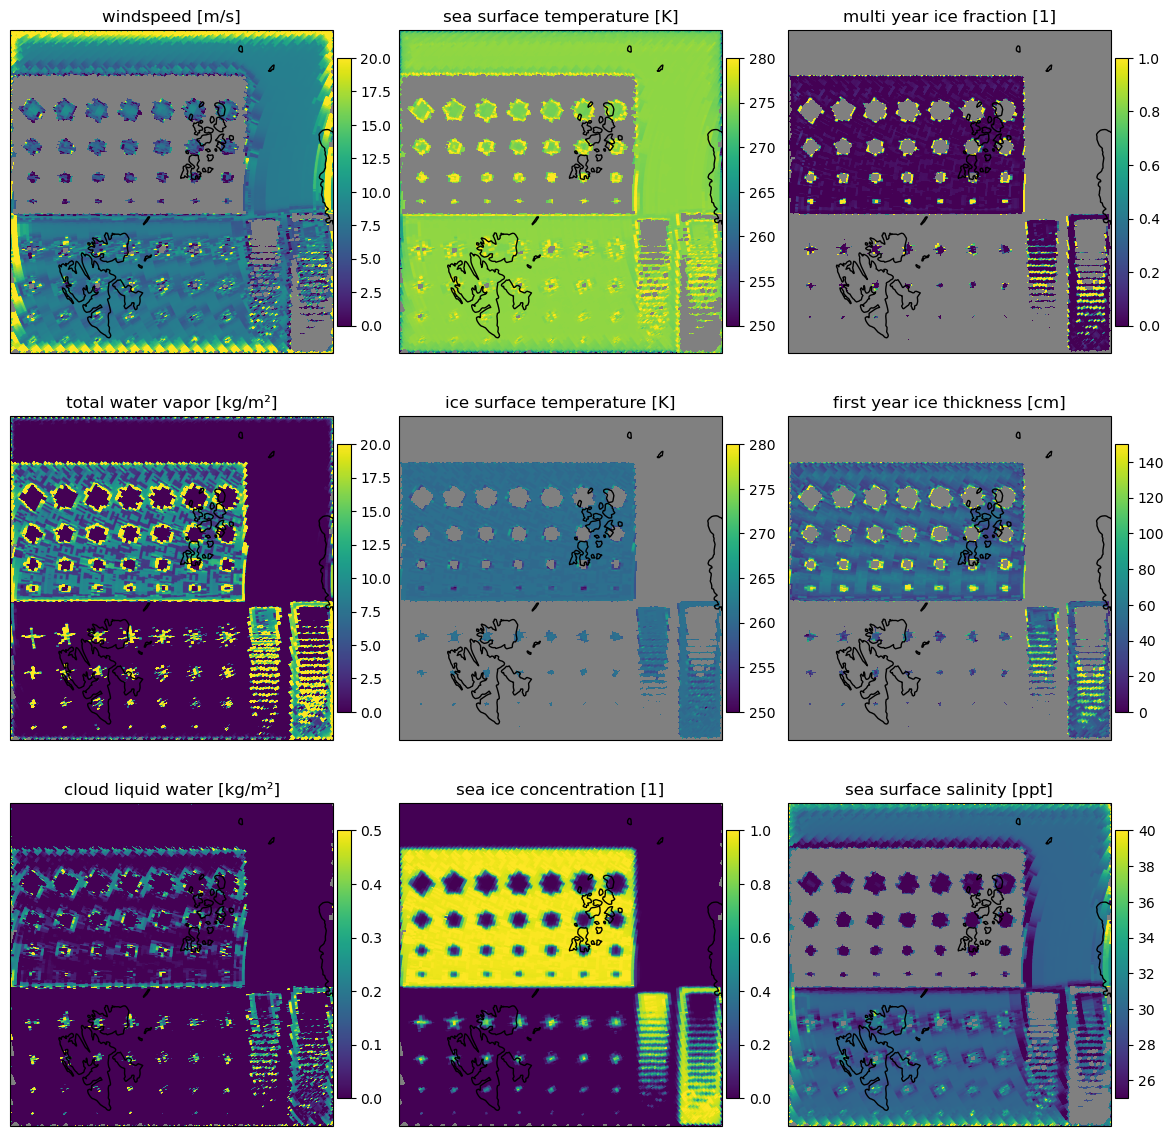

Python: None

In [18]:
let dir="forward"
    fig=plot_all_params(scene2,dir,swath=false,mask=(:sic,),errors=:false,save="figures/scene2_oem_results.png")
    display("image/png",fig)
    pyplot.close(fig)
end

In this test scene, the different shapes and patterns are a major challenge for the retrieval and the smearing introduced by the lower resoultion channels is more apparent. For the mask here again only the retrieved ice concentration is used, like before with the radiometric scene.

Then we read again the input and apply the retrieval to that data for comparison.

In [19]:
gdata2 = let
    test2data,lea,imextent,surfaces=read_testscene(fns.scene2.input)
    pygc.collect()
    GC.gc()
    tdat,terr,tres=run_oem(deepcopy(test2data))
    NamedTuple{(:ws, :twv, :clw, :sst, :ist, :sic, :myi, :sit, :sss)}(reshape(tdat[:,i],1400,1400)[end:-1:1,:] for i in 1:9)
end

(ws = [8.606775086416485 8.606775086416485 … 8.606775086416485 8.606775086416485; 8.606775086416485 8.606775086416485 … 8.606775086416485 8.606775086416485; … ; 8.606775086416485 8.606775086416485 … 5.005320129782621 5.005320129782621; 8.606775086416485 8.606775086416485 … 5.005320129782621 5.005320129782621], twv = [-1.041070439268596 -1.041070439268596 … -1.041070439268596 -1.041070439268596; -1.041070439268596 -1.041070439268596 … -1.041070439268596 -1.041070439268596; … ; -1.041070439268596 -1.041070439268596 … 3.5621438953996463 3.5621438953996463; -1.041070439268596 -1.041070439268596 … 3.5621438953996463 3.5621438953996463], clw = [-0.19217235888038275 -0.19217235888038275 … -0.19217235888038275 -0.19217235888038275; -0.19217235888038275 -0.19217235888038275 … -0.19217235888038275 -0.19217235888038275; … ; -0.19217235888038275 -0.19217235888038275 … 0.019041203464365785 0.019041203464365785; -0.19217235888038275 -0.19217235888038275 … 0.019041203464365785 0.019041203464365785], 

We focus on the sea ice concentration also on test scene 2.

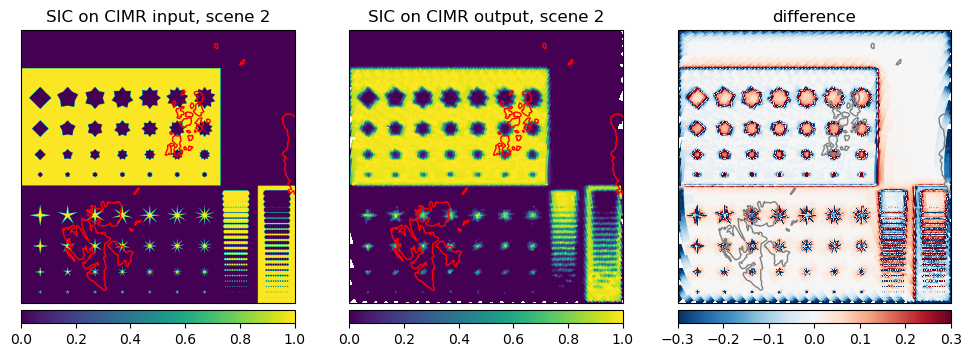

In [20]:
let scene2 = scene2["forward"]
    fig = pyplot.figure(figsize=(12, 8))
    scene=2
    ax = fig.add_subplot(131, projection=ccrs)
    ax.set_title("SIC on CIMR input, scene $scene")

    im=ax.imshow(gdata2.sic ,zorder=1,extent=imextent,vmin=0,vmax=1)
    ax.coastlines(color="red")
    pyplot.colorbar(im,orientation="horizontal",pad=0.01)

    ax = fig.add_subplot(132, projection=ccrs)
    ax.set_title("SIC on CIMR output, scene $scene")
    outsic=OEM.project_data_to_area_nn(scene2.dat[:,6],scene2.lat,scene2.lon,lea)

    im=ax.imshow(outsic, vmin=0, vmax=1, extent=leaextent, transform=ccrs)
    ax.coastlines(color="red")
    pyplot.colorbar(im,orientation="horizontal",pad=0.01)

    ax = fig.add_subplot(133, projection=ccrs)
    ax.set_title("difference")
    im=ax.imshow(outsic.-gdata2.sic, vmin=-0.3, vmax=0.3, extent=leaextent, transform=ccrs,cmap="RdBu_r")
    pyplot.colorbar(im,orientation="horizontal",pad=0.01)

    ax.coastlines(color="gray")
    pyplot.savefig("figures/sic_comparison_scene2.png",dpi=200,bbox_inches="tight")
    display("image/png",fig)
    pyplot.close(fig)
    fig=nothing
end

Also for this scene we can calculate the performance of the retrieval on the input data and the L1b data. The results are shown in table {numref}`performance-2`. The bias is very small, while the RMSE is similar to the RMSE in the radiometric scene. 

In [42]:
calculate_overall_performances([scene2], [gdata2], ["combined"], [100]) |> x-> markdown_table(x,"scene 1","2", include_mean=true ) |> x->display("text/markdown",Markdown.parse(x))

````markdown
```{list-table} Performance metric for scene 1
:name: "performance-2"
:header-rows: 1

# table content (skipped in notebook) ```
````

|    Variable | cb mean value | cb mean(diff) | cb std(diff) |
| -----------:| -------------:| -------------:| ------------:|
|    WS [m/s] |         7.208 |        -0.960 |        3.977 |
| TWV [kg/m²] |         0.746 |         2.173 |       14.140 |
| CLW [kg/m²] |        -0.110 |         0.026 |        0.175 |
|     SST [K] |       274.980 |         0.171 |        1.594 |
|     IST [K] |       260.253 |        -0.266 |        1.490 |
|     SIC [1] |         0.332 |         0.007 |        0.172 |
|     MYI [1] |         0.196 |         0.122 |        0.415 |
|    SIT [cm] |        84.410 |        14.630 |       63.438 |
|   SSS [ppt] |        29.957 |        -0.882 |        2.687 |
